## Carga e Preparação dos Dados

In [1]:
# Versão da Linguagem Python
from platform import python_version
print(python_version())

3.10.14


In [ ]:
!conda install pandas

In [2]:
# Imports
import random
import sagemaker
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


ModuleNotFoundError: No module named 'seaborn'

## Carga e Preparação dos Dados

In [ ]:
from sagemaker import get_execution_role
role = get_execution_role()
print(role)

In [ ]:
s3_bucket = 'eduardo-project-medical-data'    #nome do seu bucket
prefix = 'dados'   #diretorio dos arquivos

In [3]:
raiz = 's3://{}/{}/'.format(s3_bucket, prefix)
print(raiz)

NameError: name 's3_bucket' is not defined

In [6]:
df = pd.read_csv(raiz + 'dataset.csv')

In [7]:
df.head()    #para ver as primeiras linhas da tabela, ou "cabeça" / to see the fisrts lines in the table or "head" 

,class,bmi,diastolic_bp_change,systolic_bp_change,respiratory_rate
0,No,16.192875,14.000000,19.000000,2.146700
1,No,13.383857,4.000000,3.000000,0.000000
2,No,28.554000,6.000000,12.000000,2.065591
3,No,3.536667,5.725649,1.635738,0.571832
4,No,16.561000,11.451297,8.728523,2.099426


In [8]:
df.shape     #para ver shape formato dos dados, nesse caso 5 colunas e 9948 linhas  / to view the data format or "shape" in this case 5 colums and 9948 lines

(9948, 5)

## Análise Exploratória

In [9]:
df.describe()

,bmi,diastolic_bp_change,systolic_bp_change,respiratory_rate
count,9948.000000,9948.000000,9948.000000,9948.000000
mean,15.732258,5.881994,9.591503,1.021472
std,9.703593,5.896722,10.371288,1.231041
min,0.122124,0.000000,0.000000,0.000000
25%,7.455795,1.225649,2.000000,0.000000
50%,14.613946,4.000000,6.728523,0.836660
75%,22.918650,9.000000,14.000000,1.634458
max,50.900000,40.000000,141.000000,29.444864


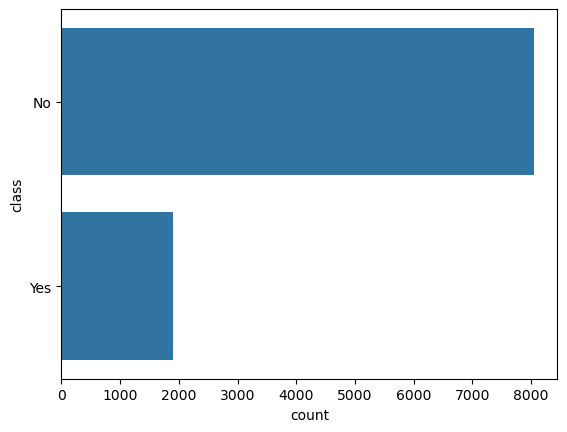

In [10]:
sns.countplot(df['class'], label = 'Count')
plt.show()

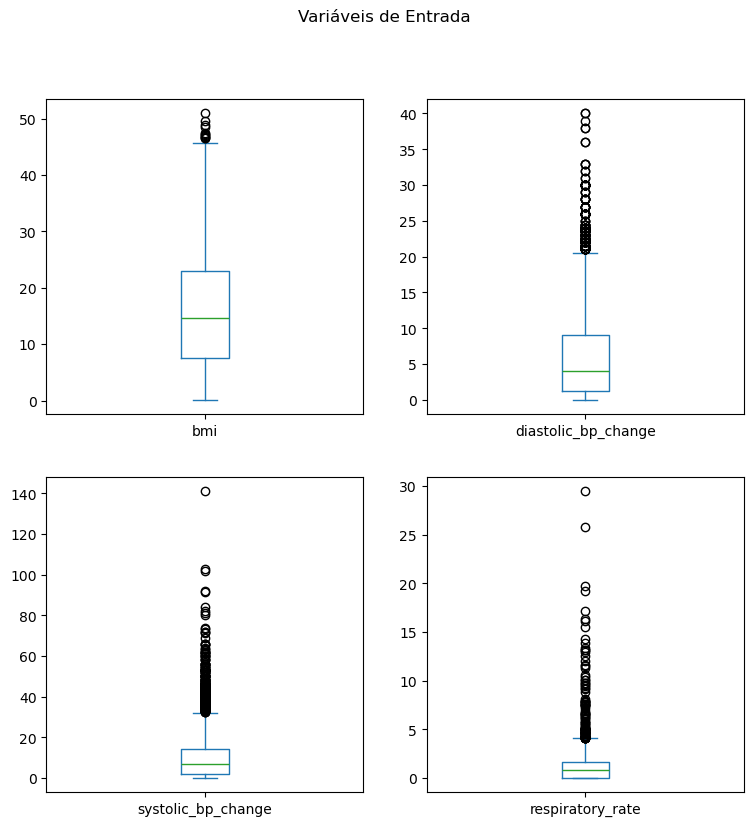

In [11]:
df.plot(kind = 'box', subplots = True, layout = (2,2), sharex = False, sharey = False, figsize = (9,9), 
        title = 'Variáveis de Entrada')
plt.show()

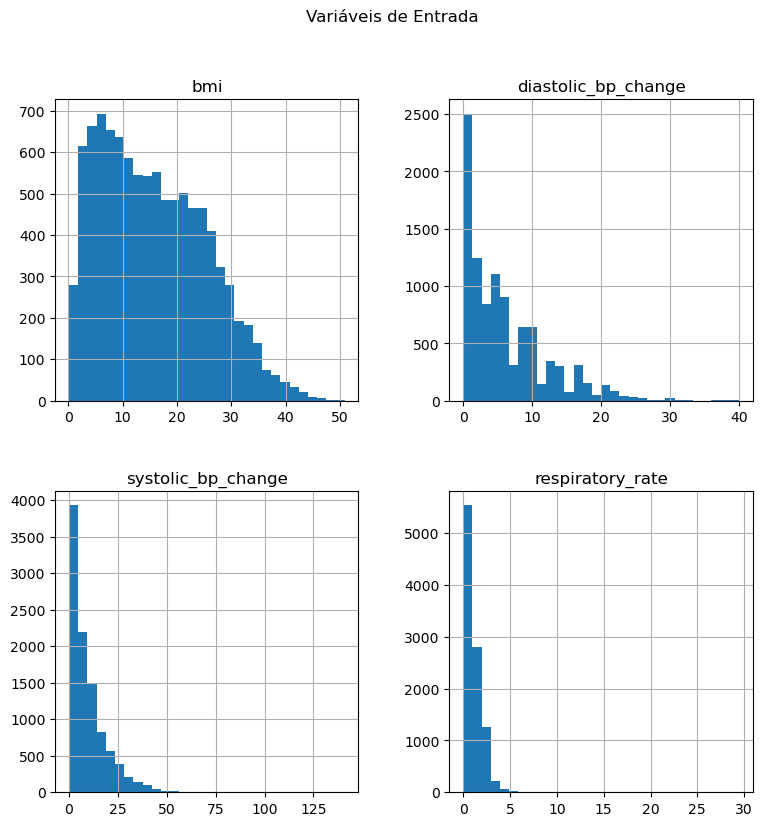

In [12]:
df.hist(bins = 30, figsize = (9,9))
pl.suptitle("Variáveis de Entrada")
plt.show()

## Pré-Processamento dos Dados

In [13]:
X = df[['bmi', 'diastolic_bp_change', 'systolic_bp_change', 'respiratory_rate']]
y = df['class']

In [14]:
# Encoder
label_encoder = LabelEncoder()
label_encoder.fit(['Yes', 'No'])
y = label_encoder.transform(y)

In [15]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
# Divisão em dados de treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state = 123)

In [17]:
X_treino.shape

(7461, 4)

In [18]:
X_teste.shape

(2487, 4)

In [19]:
# Padronização
scaler = StandardScaler()
X_treino = scaler.fit_transform(X_treino)
X_teste = scaler.transform(X_teste)

In [20]:
# Dataframe de treino
X_treino = pd.DataFrame(X_treino, columns = ['bmi', 'diastolic_bp_change', 'systolic_bp_change', 'respiratory_rate'])
y_treino = pd.DataFrame(y_treino, columns = ['class'])
df_treino = pd.concat([y_treino, X_treino], axis = 1)
df_treino.head()

,class,bmi,diastolic_bp_change,systolic_bp_change,respiratory_rate
0,0,-1.483765,-1.003436,-0.927406,-0.817379
1,1,0.947850,-1.003436,-0.927406,-0.662177
2,0,-1.034765,2.206180,2.057467,-0.817379
3,0,-1.406122,0.179054,-0.445975,-0.817379
4,0,0.366195,-0.665582,0.228029,-0.431359


In [21]:
# Dataframe de teste
X_teste = pd.DataFrame(X_teste, columns = ['bmi', 'diastolic_bp_change', 'systolic_bp_change', 'respiratory_rate'])
y_teste = pd.DataFrame(y_teste, columns = ['class'])
df_teste = pd.concat([y_teste, X_teste], axis=1)
df_teste.head()

,class,bmi,diastolic_bp_change,systolic_bp_change,respiratory_rate
0,0,-0.940089,-0.403964,-0.279542,-0.817379
1,0,-0.502614,-0.665582,0.131742,-0.362450
2,0,1.078473,0.347981,0.228029,-0.817379
3,1,-0.636164,-0.251491,0.587034,-0.817379
4,1,-0.528479,2.037253,1.383463,0.185934


In [22]:
# Dataframe para batch normalization
batch_teste_df = df_teste.drop(['class'], axis = 1)
batch_teste_df.head()

,bmi,diastolic_bp_change,systolic_bp_change,respiratory_rate
0,-0.940089,-0.403964,-0.279542,-0.817379
1,-0.502614,-0.665582,0.131742,-0.362450
2,1.078473,0.347981,0.228029,-0.817379
3,-0.636164,-0.251491,0.587034,-0.817379
4,-0.528479,2.037253,1.383463,0.185934


In [23]:
# Salva os dados processados no S3
df_treino.to_csv(raiz + 'treino.csv', header = False, index = False)
df_treino.to_csv(raiz + 'treino_with_header.csv', header = True, index = False)
df_teste.to_csv(raiz + 'teste.csv', header = False, index = False)
batch_teste_df.to_csv(raiz + 'batch_teste.csv', header = False, index = False)

## Dados Sintéticos Para Simulação

In [24]:
def get_random_val():
    val = random.uniform(0, 1)
    return round(val, 6)

In [25]:
def generate_row():
    row = []
    for _ in range(4):
        row.append(get_random_val())
    return row  

In [26]:
def generate_dataset():
    rows = []
    for _ in range(20):
        rows.append(generate_row())
    return rows 

In [27]:
rows = generate_dataset() 

In [28]:
df = pd.DataFrame(rows, columns = ['bmi', 'diastolic_bp_change', 'systolic_bp_change', 'respiratory_rate'])

In [29]:
df.head()

,bmi,diastolic_bp_change,systolic_bp_change,respiratory_rate
0,0.711926,0.085225,0.893307,0.285786
1,0.016635,0.116520,0.609608,0.786748
2,0.951981,0.682145,0.700060,0.920371
3,0.982942,0.410995,0.603343,0.272795
4,0.838826,0.665036,0.137101,0.956780


In [30]:
df.to_csv(raiz + 'dados_sinteticos.csv', header = False, index = False)

## Fim